In [1]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import seaborn as sns
sns.set(style='darkgrid')


import matplotlib.pyplot as plt

from keras_tqdm import TQDMNotebookCallback


# fix random seed for reproducibility
np.random.seed(42)
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

Using TensorFlow backend.


In [2]:
voc_size = 20000
max_sentence_length = 30
emb_dim = 100

In [3]:
import pandas as pd
import codecs
from tqdm import tqdm

def load_dataset(path):
    dataset = pd.DataFrame(columns=['X', 'y1', 'y2'])
    #print('Loading dataset...')
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as fdata:
        for line in tqdm(fdata.readlines()):
            line_split = line.split()
            formated = ' '.join(line_split[:-2])
            dataset.loc[-1] = [formated, line_split[-2], line_split[-1]]  # adding a row
            dataset.index = dataset.index + 1  # shifting index
            dataset = dataset.sort_index()  # sorting by index
    return dataset

In [4]:
def so_load_data(path):
    with open(path, encoding="utf8") as f:
        content = f.read().splitlines()
    # you may also want to remove whitespace characters like \n at the end of each line
    return [x.rstrip('\\n') for x in content]

In [5]:
def load_dataset_ext(path):
    df = pd.read_csv(path, index_col=0)
    df_droped = df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'])
    df_droped.columns = ['y', 'X']
    return df_droped.replace([0, 1], 'OFFENSE').replace(2, 'OTHER')

In [6]:
def load_dataset_ext_multiclass(path):
    df = pd.read_csv(path, index_col=0)
    df_droped = df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'])
    df_droped.columns = ['y', 'X']
    return df_droped.replace(0, 'Hatespeech').replace(1, 'Offensive').replace(2, 'Neither')

In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re

stopwords_german = set(stopwords.words('german'))

usernamePattern = re.compile('@[A-Za-z0-9_]{1,15}')
urlPattern = re.compile('(https?:\/\/)[\/.:\w(1-9)]*\s?')
andPattern = re.compile('&amp;')
lbrPattern = re.compile('|LBR|')
stemmer = SnowballStemmer("german")
tkz = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

def tokenize(text):
    text = re.sub(usernamePattern, "",  text)
    text = re.sub(urlPattern, "",  text)
    text = re.sub(andPattern, "und", text)
    text = re.sub(lbrPattern, "",  text)
    output = []
    tokens = tkz.tokenize(text)
    for token in tokens:
        #if token not in stopwords_german:
        if len(token) > 1:
            if token[0] == '#':
                output.append('#')
                token = token[1:]
                #output.append(stemmer.stem(token))
            subtoken = token.split('-')
            if len(subtoken) > 1:
                for t in subtoken:
                    output.append(t)
            else:
                output.append(token)
    return output

In [8]:
import pyphen

from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re

stopwords_german = set(stopwords.words('german'))

usernamePattern = re.compile('@[A-Za-z0-9_]{1,15}')
urlPattern = re.compile('(https?:\/\/)[\/.:\w(1-9)]*\s?')
andPattern = re.compile('&amp;')
lbrPattern = re.compile('\|LBR\|')
stemmer = SnowballStemmer("german")
tkz = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
dic = pyphen.Pyphen(lang='de')

def tokenize_syl(text):
    text = re.sub(usernamePattern, "",  text)
    text = re.sub(urlPattern, "",  text)
    text = re.sub(andPattern, "und", text)
    text = re.sub(lbrPattern, "",  text)
    output = []
    tokens = tkz.tokenize(text)
    for token in tokens:
        #if token not in stopwords_german:
        if len(token) > 1:
            if token[0] == '#':
                output.append('#')
                token = token[1:]
                #output.append(stemmer.stem(token))
            subtoken = dic.inserted(token).split('-')
            if len(subtoken) > 1:
                for t in subtoken:
                    output.append(t)
            else:
                output.append(token)
    return output

In [9]:
dataset = load_dataset(path = 'germeval2018.training.txt')

100%|█████████████████████████████████████████████████████████████████████████████| 5009/5009 [00:12<00:00, 392.95it/s]


In [10]:
dataset_test_raw = so_load_data(path = 'germeval2018.test.txt')

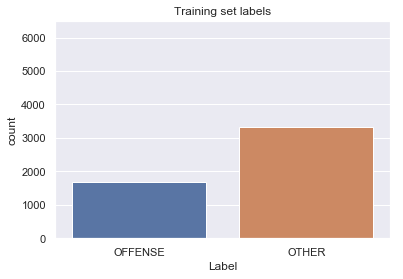

In [11]:
sns_plot = sns.countplot(dataset.y1, order=['OFFENSE', 'OTHER']).get_figure()
plt.xlabel('Label')
plt.title('Training set labels')
plt.ylim(0, 6500)
sns_plot.savefig("plot_germeval.png")

In [12]:
dataset_own_raw = load_dataset(path = 'export.tsv')

100%|█████████████████████████████████████████████████████████████████████████████| 3728/3728 [00:09<00:00, 393.45it/s]


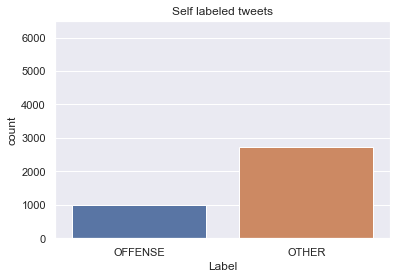

In [13]:
sns_plot = sns.countplot(dataset_own_raw.y1, order=['OFFENSE', 'OTHER']).get_figure()
plt.xlabel('Label')
plt.title('Self labeled tweets')
plt.ylim(0, 6500)
sns_plot.savefig("plot_self.png")

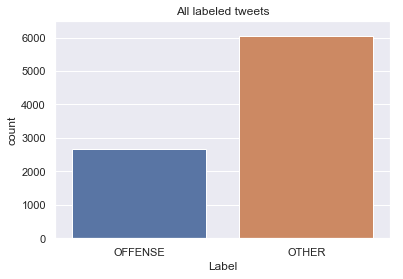

In [14]:
sns_plot = sns.countplot(np.concatenate([dataset_own_raw.y1.values, dataset.y1.values]) , order=['OFFENSE', 'OTHER']).get_figure()
plt.xlabel('Label')
plt.title('All labeled tweets')
plt.ylim(0, 6500)
sns_plot.savefig("plot_all.png")

In [15]:
dataset_ext_mc = load_dataset_ext_multiclass('labeled_data.csv')

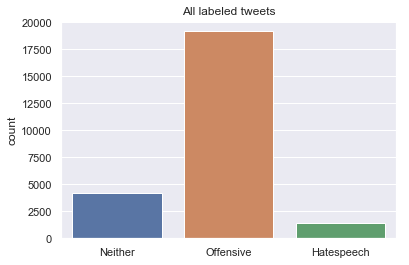

In [16]:
sns_plot = sns.countplot(dataset_ext_mc.y.values).get_figure()
#plt.xlabel('Label')
plt.title('All labeled tweets')
#plt.ylim(0, 6500)
sns_plot.savefig("plot_ext.png")

In [17]:
dataset_ext = load_dataset_ext('labeled_data.csv')

Text(0.5,1,'Number of OFFENSIVE and OTHER tweets')

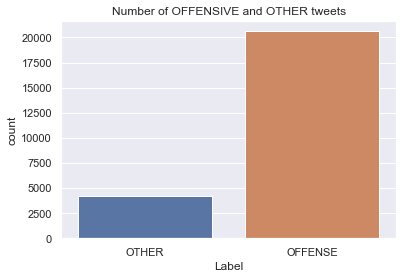

In [18]:
sns.countplot(dataset_ext.y)
plt.xlabel('Label')
plt.title('Number of OFFENSIVE and OTHER tweets')

In [19]:
dataset_ext_mc = load_dataset_ext_multiclass('labeled_data.csv')

In [20]:
def encode_label_bin(y, predicted_label):
    choose = lambda l : 1 if l == predicted_label else 0
    return [choose(l) for l in y]

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = dataset['X'].values
y = dataset['y1'].values

X_own = dataset_own_raw['X'].values
y_own = dataset_own_raw['y1'].values

X_all = np.concatenate([X, X_own])
y_all = np.concatenate([y, y_own])

X_ext = dataset_ext['X'].values
y_ext = dataset_ext['y'].values

#y_ext_mc = dataset_ext_mc.y.astype(int).values
#ohe = OneHotEncoder()
#y_ext_mc_ohe = ohe.fit_transform(y_ext_mc.reshape(-1,1))

y = encode_label_bin(y, 'OFFENSE')
y_own = encode_label_bin(y_own, 'OFFENSE')
y_all = encode_label_bin(y_all, 'OFFENSE')
y_ext = encode_label_bin(y_ext, 'OFFENSE')

#X_train_raw, X_test_raw, y_train, y_test = train_test_split(np.concatenate([X, X_own]), np.concatenate([y, y_own]), test_size=0.1, random_state=42)
#X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_all, y_all, test_size=0.1, random_state=42)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_all, y_all, test_size=0.1, random_state=42)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
vec = CountVectorizer(tokenizer=tokenize)
vec.fit(X_train_raw)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x000001E1EEB16378>,
        vocabulary=None)

In [24]:
bag_of_words = vec.transform(X_train_raw)
sum_words = bag_of_words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [25]:
len(words_freq)

23041

In [26]:
def X_vec(X, top_words):
    output = []
    for x in X:
        tokens_output = []
        tokens = tokenize(x)
        for token in tokens:
            if token not in top_words:
                tokens_output.append('<unk>')
            else:
                tokens_output.append(token)
        output.append(tokens_output)
    return output

In [27]:
freq_dic = dict(words_freq[:voc_size])
freq_dic['<unk>'] = 9999999999
#freq_dic = {key: value for (key, value) in iterable}

In [28]:
freq_dic.pop('lbr', None)

1155

In [29]:
X_train_top = X_vec(X_train_raw, freq_dic)
X_test_top = X_vec(X_test_raw, freq_dic)
X_test_final_top = X_vec(dataset_test_raw, freq_dic)

In [30]:
freq_keys_list = list(freq_dic.keys())
create_index_list = lambda X : [[freq_keys_list.index(x) for x in token] for token in tqdm(X)]

In [31]:
X_train_index=create_index_list(X_train_top)
X_test_index=create_index_list(X_test_top)
X_test_final_index=create_index_list(X_test_final_top)

100%|█████████████████████████████████████████████████████████████████████████████| 3532/3532 [00:10<00:00, 338.70it/s]


In [32]:
# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train_index, maxlen=max_sentence_length)
X_test = sequence.pad_sequences(X_test_index, maxlen=max_sentence_length)
X_test_final = sequence.pad_sequences(X_test_final_index, maxlen=max_sentence_length)

In [33]:
X_test_final

array([[    0,     0,     0, ...,  9450,   734, 11889],
       [    0,     0,     0, ..., 13318,  4162,  7371],
       [    0,     0,     0, ...,  7371,  6687,  7371],
       ...,
       [    0,     0,     0, ...,  7371,  4532,  3138],
       [    0,     0,     0, ..., 16294, 12146, 10720],
       [    0,     0,     0, ...,  7371, 13992, 15727]])

In [34]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

word2vec = Word2Vec.load('word2vec_nostem_stopword.model')
#word2vec = KeyedVectors.load_word2vec_format('twitter-de_d100_w7_min50.bin', binary = True)

d:\windows\programme\python\3.5.4\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [35]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((voc_size, emb_dim))
index = 0;
for word in freq_keys_list:
    #word = tup[0]
    if index > voc_size - 1:
        break
    else:
        if word in word2vec.wv.vocab:
            embedding_matrix[index] = word2vec.wv.word_vec(word)
        else:
            embedding_matrix[index] = np.random.uniform(-0.25,0.25,emb_dim)
    index += 1

In [36]:
from sklearn.preprocessing import StandardScaler, normalize

sc = StandardScaler()
embedding_matrix = normalize(embedding_matrix)

In [37]:
from keras import regularizers
from keras.layers import Conv1D, MaxPooling1D, Concatenate, concatenate


text_input_layer = Input(shape=(max_sentence_length,), dtype='int32')
doc_embedding   = Embedding(voc_size, 100, weights=[embedding_matrix],
#doc_embedding   = Embedding(voc_size, 100, 
                            input_length=max_sentence_length, trainable=False)(text_input_layer)
d1 = Dropout(.3)(doc_embedding)
convs = []
filter_sizes = (np.arange(10)+1).tolist()

for filter_size in filter_sizes:
    l_conv = Conv1D(filters=64, kernel_size=filter_size, padding='valid', activation='relu')(d1)
    convs.append(l_conv)

cnn_feature_maps = Concatenate(axis=1)(convs)
sentence_encoder = LSTM(100,return_sequences=False)(cnn_feature_maps)
d2 = Dropout(.3)(sentence_encoder)
#fc_layer =Dense(30, activation="relu")(d2)
#d3 = Dropout(.25)(fc_layer)
output_layer = Dense(1,activation="sigmoid")(d2)

model = Model(inputs=[text_input_layer], outputs=[output_layer])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, shuffle=True, epochs=1, batch_size=32, verbose=0, callbacks=[TQDMNotebookCallback()])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 100)      2000000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30, 100)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 30, 64)       6464        dropout_1[0][0]                  
__________________________

In [38]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 72.20%


In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

y_pred_conv = (y_pred.reshape(1,-1)[0] > .5)*1
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred_conv)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred_conv)*100))
print("Precission: %.2f%%" % (precision_score(y_test, y_pred_conv)*100))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred_conv)*100))
print(classification_report(y_test, y_pred_conv))
print(confusion_matrix(y_test, y_pred_conv))

#y_pred = np.argmax(y_pred, axis=1)
#y_test_conv = np.squeeze(np.asarray(np.argmax(y_test, axis=1)))
#print("F1: %.2f%%" % (f1_score(y_test_conv, y_pred, average='micro')*100))
#print(classification_report(y_test_conv, y_pred))

Accuracy: 72.20%
F1: 25.23%
Precission: 67.21%
Recall: 15.53%
             precision    recall  f1-score   support

          0       0.73      0.97      0.83       610
          1       0.67      0.16      0.25       264

avg / total       0.71      0.72      0.65       874

[[590  20]
 [223  41]]


In [40]:
def print_tweet(var):
    print('Tweet: %s' % X_test_raw[var])
    print('Tweet tokenized: %s' % tokenize(X_test_raw[var]))
    print('actual label: %s' % (y_test[var]))
    print('predicted label: %s' % ((y_pred.reshape(1,-1)[0][var]>.5)*1))
    print('probability: %s' % (y_pred.reshape(1,-1)[0][var]))
    print()

In [41]:
unsure = (y_pred.reshape(1,-1)[0] < .6) & (y_pred.reshape(1,-1)[0] > .4)

In [42]:
sure = (y_pred.reshape(1,-1)[0] < .1) | (y_pred.reshape(1,-1)[0] > .9)

In [43]:
fails = np.absolute(y_pred.reshape(1,-1)[0] - y_test)

In [44]:
from itertools import compress
unsure = list(compress(range(len(y_test)), unsure))

In [45]:
from itertools import compress
sure = list(compress(range(len(y_test)), sure))

In [46]:
pred_label = (y_pred.reshape(1,-1)[0] > .5)
for x in sure:
    if pred_label[x] != y_test[x]:
        print_tweet(x)

Tweet: Lachkick was für 1 ehrenloser Hurensohn kann man sein als trainer 1 tag vor Turnierbeginn seinen Wechsel nach Real bekannt zu geben
Tweet tokenized: ['lachkick', 'was', 'für', 'ehrenloser', 'hurensohn', 'kann', 'man', 'sein', 'als', 'trainer', 'tag', 'vor', 'turnierbeginn', 'seinen', 'wechsel', 'nach', 'real', 'bekannt', 'zu', 'geben']
actual label: 1
predicted label: 0
probability: 0.080933236

Tweet: @DoraBromberger Die Polizei wollte /durfte gegen "brennende,israelische Fahnen" vorgehen. |LBR| Von " Todesaufrufe,Hassparolen,Morddrohungen der muslimischen Goldstücke unterbinden" etc stand da nichts. |LBR| #Chanukka #Washingtonplatz #Berlin
Tweet tokenized: ['die', 'polizei', 'wollte', 'durfte', 'gegen', 'brennende', 'israelische', 'fahnen', 'vorgehen', 'von', 'todesaufrufe', 'hassparolen', 'morddrohungen', 'der', 'muslimischen', 'goldstücke', 'unterbinden', 'etc', 'stand', 'da', 'nichts', '#', 'chanukka', '#', 'washingtonplatz', '#', 'berlin']
actual label: 1
predicted label: 

In [47]:
for x in unsure:
    print_tweet(x)

Tweet: @Baerendeutscher Wer keine Angst vorm Teufel hat, der braucht auch keinen Gott! |LBR| 👇🤘🖕👹
Tweet tokenized: ['wer', 'keine', 'angst', 'vorm', 'teufel', 'hat', 'der', 'braucht', 'auch', 'keinen', 'gott']
actual label: 0
predicted label: 0
probability: 0.46000466

Tweet: @SawsanChebli @SawsanChebli ...sich damit auch noch brüsten ist schön...dämlich... |LBR| Wenn man tief genug gräbt findet man tatsächlich immer noch eine dümmere deutsche...obwohl bei Katja an der Oberfläche kratzen schon ausreicht....😃😃
Tweet tokenized: ['...', 'sich', 'damit', 'auch', 'noch', 'brüsten', 'ist', 'schön', '...', 'dämlich', '...', 'wenn', 'man', 'tief', 'genug', 'gräbt', 'findet', 'man', 'tatsächlich', 'immer', 'noch', 'eine', 'dümmere', 'deutsche', '...', 'obwohl', 'bei', 'katja', 'an', 'der', 'oberfläche', 'kratzen', 'schon', 'ausreicht', '...']
actual label: 1
predicted label: 0
probability: 0.44592768

Tweet: Ach du scheiße!!! Der Wollersheim wird ja immer hässlicher.....ich fürchte das liegt da

Tweet: @Varg_I_Veum @tagesschau Verlogene Doppelmoralistenheuchler |LBR| Der arme Hund |LBR| #Hetze
Tweet tokenized: ['verlogene', 'doppelmoralistenheuchler', 'der', 'arme', 'hund', '#', 'hetze']
actual label: 1
predicted label: 0
probability: 0.45583484

Tweet: @UlrikeDemmer @RegSprecher Sie weiß genau das sie die Schuldige ist! Mehrmals unser Grundgesetz mißachtet, um solche Mißgeburten und Bastarde in unser Land zu holen!
Tweet tokenized: ['sie', 'weiß', 'genau', 'das', 'sie', 'die', 'schuldige', 'ist', 'mehrmals', 'unser', 'grundgesetz', 'mißachtet', 'um', 'solche', 'mißgeburten', 'und', 'bastarde', 'in', 'unser', 'land', 'zu', 'holen']
actual label: 1
predicted label: 0
probability: 0.468649

Tweet: @volksfahrraeder Ich teile und kritisiere in diesem Kommentar die #Neonazis; ein Unterschied. Wenn man die einfach unkommentiert ihren Mist in den Äther pusten lässt, finde ich das schlimmer!
Tweet tokenized: ['ich', 'teile', 'und', 'kritisiere', 'in', 'diesem', 'kommentar', 'die', '#'

Tweet: @StephanDerrick2 was sie so alles über mich wissen... gehen sie doch schon mal los und holen den wagen. ach ne, das war ja n fake. wie ihr account?
Tweet tokenized: ['was', 'sie', 'so', 'alles', 'über', 'mich', 'wissen', '...', 'gehen', 'sie', 'doch', 'schon', 'mal', 'los', 'und', 'holen', 'den', 'wagen', 'ach', 'ne', 'das', 'war', 'ja', 'fake', 'wie', 'ihr', 'account']
actual label: 0
predicted label: 1
probability: 0.53687376

Tweet: @panemetc62 ach so. na klar. na dann alle man an die gewehre... #ohmann
Tweet tokenized: ['ach', 'so', 'na', 'klar', 'na', 'dann', 'alle', 'man', 'an', 'die', 'gewehre', '...', '#', 'ohmann']
actual label: 0
predicted label: 0
probability: 0.4507798

Tweet: @_lennartvoss @fgabrielEU @afd_thl Was ist dir denn lieber ?? Burkha mit günem Punkt !! Oder ein verschwulter Braunhäutiger mit Federboa !! Herrgott hau die linken weg ! bitte
Tweet tokenized: ['was', 'ist', 'dir', 'denn', 'lieber', 'burkha', 'mit', 'günem', 'punkt', 'oder', 'ein', 'verschwulte

Tweet: Super jetzt kommentiert eine Frau das Spiel, wirkt alles gleich unsympathischer, tut doch in den Ohren weh. Ich mach aus. Typisch ARD und ZDF. #ARGISL #WM2018
Tweet tokenized: ['super', 'jetzt', 'kommentiert', 'eine', 'frau', 'das', 'spiel', 'wirkt', 'alles', 'gleich', 'unsympathischer', 'tut', 'doch', 'in', 'den', 'ohren', 'weh', 'ich', 'mach', 'aus', 'typisch', 'ard', 'und', 'zdf', '#', 'argisl', '#', 'wm2018']
actual label: 1
predicted label: 0
probability: 0.44182202

Tweet: Wenn du in 57462 Neger wohnst und von jemand aus Unterneger zugeparkt wirst #metwo
Tweet tokenized: ['wenn', 'du', 'in', '57462', 'neger', 'wohnst', 'und', 'von', 'jemand', 'aus', 'unterneger', 'zugeparkt', 'wirst', '#', 'metwo']
actual label: 0
predicted label: 0
probability: 0.40276816

Tweet: @anna_IIna Welt-N24....wo auch immer die ihre Pseudo-Historiker ausgraben..und zum Reden wiederbeleben, aber sie tuns..😂😂😂
Tweet tokenized: ['welt', 'n', '24', '...', 'wo', 'auch', 'immer', 'die', 'ihre', 'pseudo

Tweet: @MD_Franz Das gibt eine neue Einnahmequelle für das Pack....angedichtete Familien werden meistbietend verkauft
Tweet tokenized: ['das', 'gibt', 'eine', 'neue', 'einnahmequelle', 'für', 'das', 'pack', '...', 'angedichtete', 'familien', 'werden', 'meistbietend', 'verkauft']
actual label: 1
predicted label: 0
probability: 0.45146266

Tweet: Tunesien schließt 80 Moscheen im Lande, weil der Terror mit dem Islam nichts zu tun hat!
Tweet tokenized: ['tunesien', 'schließt', '80', 'moscheen', 'im', 'lande', 'weil', 'der', 'terror', 'mit', 'dem', 'islam', 'nichts', 'zu', 'tun', 'hat']
actual label: 0
predicted label: 0
probability: 0.49404615

Tweet: @anna_IIna Ja, die hätten besser ihre Pässe wegwerfen sollen, dann wären sie bei Merkel willkommen gewesen!!
Tweet tokenized: ['ja', 'die', 'hätten', 'besser', 'ihre', 'pässe', 'wegwerfen', 'sollen', 'dann', 'wären', 'sie', 'bei', 'merkel', 'willkommen', 'gewesen']
actual label: 1
predicted label: 0
probability: 0.40832

Tweet: @name Was für 

Tweet tokenized: ['spd', 'ist', 'der', 'größte', 'dreck', 'geworden', '...', 'stegner', 'und', 'schulz', 'so', 'ziemlich', 'das', 'lächerliste', 'was', 'es', 'zu', 'bieten', 'hat', '...']
actual label: 1
predicted label: 0
probability: 0.41770703

Tweet: Das Theater mit der Türkei muss beendet werden. Abzug aller |LBR| deutschen Soldaten. Wir brauchen die Türkei nicht. Dann herrscht |LBR| Ruhe.
Tweet tokenized: ['das', 'theater', 'mit', 'der', 'türkei', 'muss', 'beendet', 'werden', 'abzug', 'aller', 'deutschen', 'soldaten', 'wir', 'brauchen', 'die', 'türkei', 'nicht', 'dann', 'herrscht', 'ruhe']
actual label: 0
predicted label: 0
probability: 0.4239342

Tweet: Für die welt warst du nur ein hund Für uns aber warst du ein rassistischer hurensohn #Gauland #RIP #RIPGauland http://
Tweet tokenized: ['für', 'die', 'welt', 'warst', 'du', 'nur', 'ein', 'hund', 'für', 'uns', 'aber', 'warst', 'du', 'ein', 'rassistischer', 'hurensohn', '#', 'gauland', '#', 'rip', '#', 'ripgauland']
actual label: 

Tweet: @emrich_5933 @krippmarie Von Gauland wurde verlangt das er sich wegen ˋentsorgen‘ entschuldigen sollte... |LBR| Würde das von der Kröte auch verlangt..?
Tweet tokenized: ['von', 'gauland', 'wurde', 'verlangt', 'das', 'er', 'sich', 'wegen', 'ˋentsorgen', 'entschuldigen', 'sollte', '...', 'würde', 'das', 'von', 'der', 'kröte', 'auch', 'verlangt', '..']
actual label: 1
predicted label: 0
probability: 0.41169325

Tweet: Ja, die Bundestagswahl ist schon so gut wie gelaufen. Immer mehr Bürger erkennen, |LBR| dass der zweimal sitzen gebliebene Schulz eine Null ist.
Tweet tokenized: ['ja', 'die', 'bundestagswahl', 'ist', 'schon', 'so', 'gut', 'wie', 'gelaufen', 'immer', 'mehr', 'bürger', 'erkennen', 'dass', 'der', 'zweimal', 'sitzen', 'gebliebene', 'schulz', 'eine', 'null', 'ist']
actual label: 1
predicted label: 0
probability: 0.43359366

Tweet: @BILD Wenn man den Zulieferern die Preise diktiert braucht man sich nicht zu wundern wenn diese die Produktion mit Zeitarbeiter und billige Mi

Tweet tokenized: ['das', 'bert', 'hat', 'also', 'schon', 'wieder', 'eine', 'neue', 'am', 'start', '...', 'tja', 'der', 'findet', 'halt', 'immer', 'eine', 'dumme', '#', 'extra', '#', 'sommerhaus']
actual label: 1
predicted label: 1
probability: 0.5575703

Tweet: @erstmal_denken Hoher Anspruch im Namen und wurde für zu leicht befunden ! Du , für sie reicht einfach der Respekt nicht kennst auch den Unterschied zwischen einem Lieferwagen und einem muslimischen Terroristen nicht ! Das böse und schlimme daran ist das du das garnicht willst!
Tweet tokenized: ['hoher', 'anspruch', 'im', 'namen', 'und', 'wurde', 'für', 'zu', 'leicht', 'befunden', 'du', 'für', 'sie', 'reicht', 'einfach', 'der', 'respekt', 'nicht', 'kennst', 'auch', 'den', 'unterschied', 'zwischen', 'einem', 'lieferwagen', 'und', 'einem', 'muslimischen', 'terroristen', 'nicht', 'das', 'böse', 'und', 'schlimme', 'daran', 'ist', 'das', 'du', 'das', 'garnicht', 'willst']
actual label: 1
predicted label: 1
probability: 0.52865314

Tw

Tweet tokenized: ['was', 'geht', 'denn', 'in', 'diesem', 'trump', 'vor', 'der', 'will', 'doch', 'nur', 'unfrieden', 'stiften', 'der', 'mann', 'muss', 'sofort', 'abgewählt', 'werden']
actual label: 0
predicted label: 0
probability: 0.43687525

Tweet: Es ist widerlich sich diesen Machtpoker um Merkel mit ansehen zu müssen, zuzusehen welche Schwachmaten ausschließlich um MACHT streiten 🤢
Tweet tokenized: ['es', 'ist', 'widerlich', 'sich', 'diesen', 'machtpoker', 'um', 'merkel', 'mit', 'ansehen', 'zu', 'müssen', 'zuzusehen', 'welche', 'schwachmaten', 'ausschließlich', 'um', 'macht', 'streiten']
actual label: 1
predicted label: 1
probability: 0.5033744

Tweet: @focusonline Der Zuzug von subsidaer Geschützen ist das größte Problem. Es ist doch ein Irrsinnig Familien zusammen zu führen die das Land dann geschlossen wieder verlassen müssen. Im übrigen ist Syrien laut Pressemitteilung vom IS befreit. Wer baut diese Land dann wieder auf??
Tweet tokenized: ['der', 'zuzug', 'von', 'subsidaer', 'ge

Tweet: @nobelundfrei @DeltaFiveEcho Dieses Käseblatt ist auch nur für eins gut, aber selbst der Fisch den man damit einwickelt wäre noch beleidigt
Tweet tokenized: ['dieses', 'käseblatt', 'ist', 'auch', 'nur', 'für', 'eins', 'gut', 'aber', 'selbst', 'der', 'fisch', 'den', 'man', 'damit', 'einwickelt', 'wäre', 'noch', 'beleidigt']
actual label: 0
predicted label: 0
probability: 0.40344185

Tweet: @name @name @name @name Gegen alle Moslems, Türken, Araber, Afrikaner sein, ist keine Lösung. Das ist die Wahrheit der AfD. Sieh Dir die Demos, Veranstalltungen und Tweets von AfD nur an. Das sind keine Fakten!
Tweet tokenized: ['gegen', 'alle', 'moslems', 'türken', 'araber', 'afrikaner', 'sein', 'ist', 'keine', 'lösung', 'das', 'ist', 'die', 'wahrheit', 'der', 'afd', 'sieh', 'dir', 'die', 'demos', 'veranstalltungen', 'und', 'tweets', 'von', 'afd', 'nur', 'an', 'das', 'sind', 'keine', 'fakten']
actual label: 0
predicted label: 0
probability: 0.42990398

Tweet: Amlo, Mexikos neuer Präsident: Ein

probability: 0.4154606

Tweet: @Fraulein_Antje @principessamona Österreicher haben diesen Kurz...diesen Schnösel...der auch noch gute Politik macht..! |LBR| Sehr zum Leidwesen der deutschen Politiker die daran gemessen werden...😃
Tweet tokenized: ['österreicher', 'haben', 'diesen', 'kurz', '...', 'diesen', 'schnösel', '...', 'der', 'auch', 'noch', 'gute', 'politik', 'macht', '..', 'sehr', 'zum', 'leidwesen', 'der', 'deutschen', 'politiker', 'die', 'daran', 'gemessen', 'werden', '...']
actual label: 0
predicted label: 0
probability: 0.45375744

Tweet: Ihr habt so einen tollen Erfolg mit der NFL, ich befürchte dass American Football in naher Zukunft im PAY-TV landen wird.Siehe SKY mit DAZN,Netflix . Wenn die Profite Erwirtschaften können ,kaufen die alle Lizenzen.Nicht jeder kann oder will zu den Basisgebühren Pay-TV bezahlen.
Tweet tokenized: ['ihr', 'habt', 'so', 'einen', 'tollen', 'erfolg', 'mit', 'der', 'nfl', 'ich', 'befürchte', 'dass', 'american', 'football', 'in', 'naher', 'zukunf

In [182]:
#model.save('c-lstm_all_tweets_final.model')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [52]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [150]:
def predictions_to_txt(filename, X_test, y_pred):
    i=0
    results = []
    for x in X_test:
        line = []
        line.append(x)
        if y_pred[i] == 1:
            line.append('OFFENSE')
        else:
            line.append('OTHER')
        line.append('OTHER')
        i += 1
        results.append(line)

    predictions = results
    np.savetxt(filename, predictions, fmt=['%s', '%s', '%s'], delimiter='\t', newline='\n', \
                  header='', footer='', encoding='utf-8')

In [198]:
predictions_final = model.predict(X_test_final)
predictions_final = (predictions_final.reshape(1,-1)[0] > .5)*1

In [201]:
predictions_to_txt('upInf_coarse_3.txt', dataset_test_raw, predictions_final)